In [ ]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf
import sys
import pyprojroot

sys.path.append(str(pyprojroot.here()))
import src.pandas_missing_extension

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import LabelEncoder

/home/alex/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/nhanes/load.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pkg_resources/__init__.py:3138: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)


In [2]:
sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

In [3]:
# The "airquality" dataset is imported from the statsmodels library
airquality_df = (
    sm.datasets.get_rdataset("airquality")  # Retrieves the 'airquality' dataset from the statsmodels library
    .data  # Accesses the dataset's data
    .clean_names(  # Cleans the column names to make them more readable
        case_type = "snake"  # Converts the column names to 'snake_case' (lowercase letters with underscores)
    )
    .add_column("year", 1973)  # Adds a new column called 'year' with the value 1973 for all rows
    .assign(  # Assigns a new calculated column
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])  # Creates a new 'date' column by combining 'year', 'month', and 'day' into a datetime object
    )
    .sort_values(by = "date")  # Sorts the data by the 'date' column in ascending order
    .set_index("date")  # Sets the 'date' column as the index of the DataFrame
)

airquality_df

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


You cannot directly compare linear regression models with datasets that contain missing data because different methods for handling missing values (such as deletion or imputation) can bias the results. Imputations introduce uncertainty and may alter the data's structure, affecting the validity of comparisons between models. For a fair comparison, the same techniques should be used to handle missing data

In [4]:
# It is not a fair comparison
(
    smf.ols(
        formula="temp ~ ozone ", # + solar_r
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Sun, 09 Mar 2025",Prob (F-statistic):,2.93e-18
Time:,20:34:35,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


# Challenge: Find a linear regression model to predict the 'death' column

In [18]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [19]:
le = LabelEncoder()
survival_df["chapter_encoded"] = le.fit_transform(survival_df["chapter"])

/tmp/ipykernel_118106/4249432849.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(survival_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/seaborn/matrix.py:316: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(me

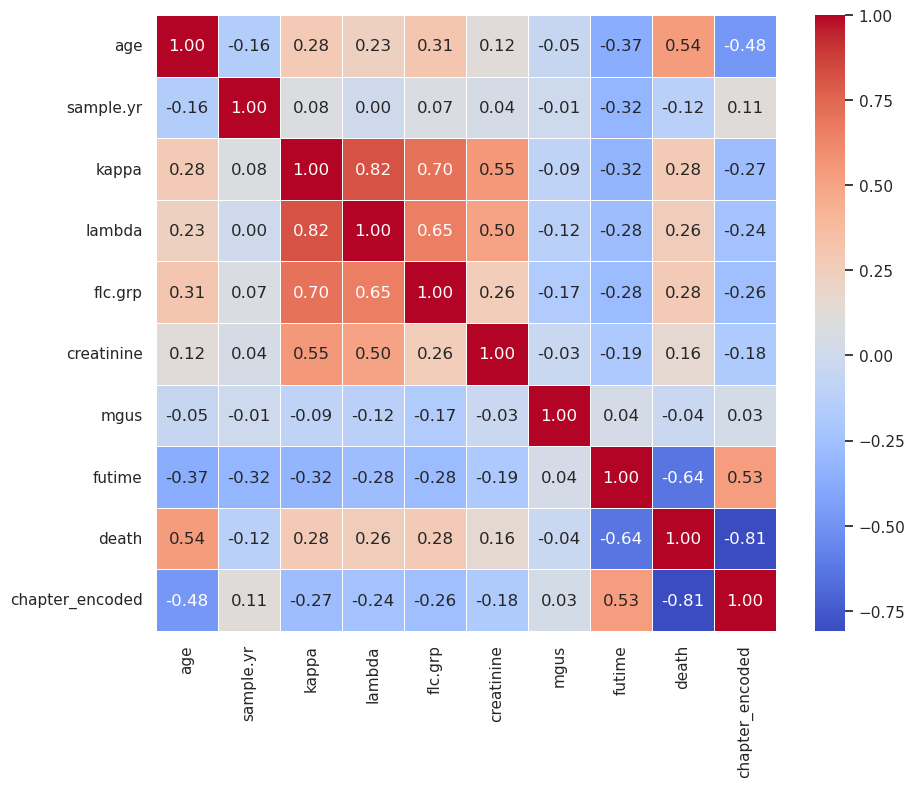

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(survival_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

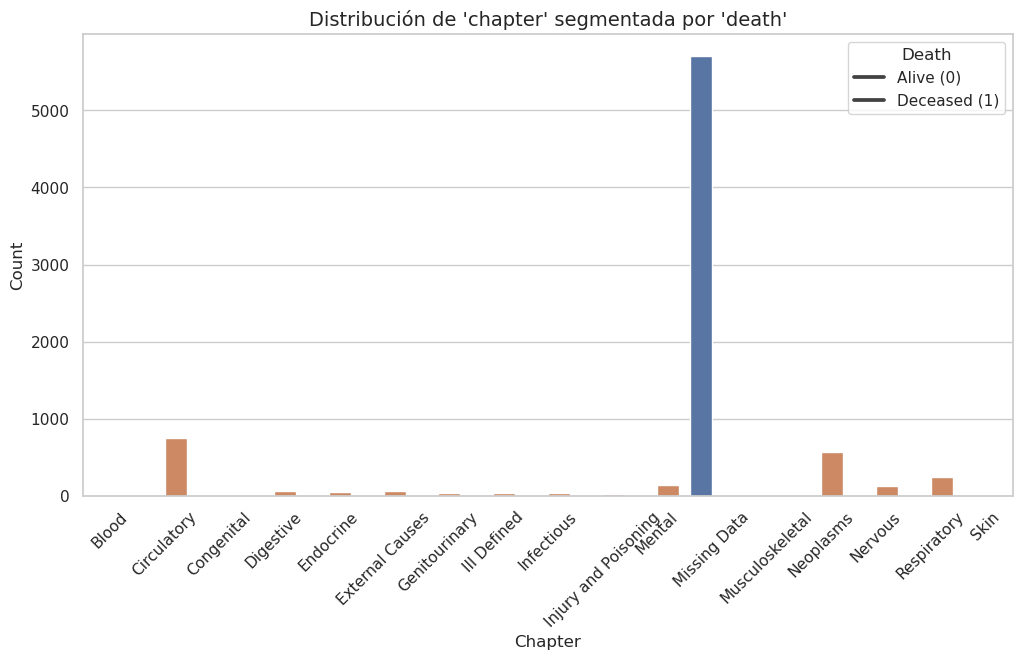

In [21]:
# Reemplazar NaN en 'chapter' por una categoría explícita
survival_df["chapter"] = survival_df["chapter"].fillna("Missing Data")

# Convertir 'chapter' a categoría para mejor orden en el gráfico
survival_df["chapter"] = survival_df["chapter"].astype("category")

# Contar casos agrupando por 'chapter' y 'death'
death_counts = survival_df.groupby(["chapter", "death"]).size().reset_index(name="count")

# Crear el gráfico de barras segmentado por 'death'
plt.figure(figsize=(12, 6))
sns.barplot(data=death_counts, x="chapter", y="count", hue="death")

# Etiquetas y título
plt.xlabel("Chapter", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribución de 'chapter' segmentada por 'death'", fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas si hay muchas categorías
plt.legend(title="Death", labels=["Alive (0)", "Deceased (1)"])
plt.show()

In [22]:
survival_df = pd.get_dummies(survival_df, columns=["chapter"], dtype=int)

In [23]:
survival_df.rename(columns={'chapter_Missing Data': 'chapter_missing_data'}, inplace=True)
survival_df.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,...,chapter_Ill Defined,chapter_Infectious,chapter_Injury and Poisoning,chapter_Mental,chapter_missing_data,chapter_Musculoskeletal,chapter_Neoplasms,chapter_Nervous,chapter_Respiratory,chapter_Skin
0,97,F,1997,5.70,4.860,10,1.7,0,85,1,...,0,0,0,0,0,0,0,0,0,0
1,92,F,2000,0.87,0.683,1,0.9,0,1281,1,...,0,0,0,0,0,0,1,0,0,0
2,94,F,1997,4.36,3.850,10,1.4,0,69,1,...,0,0,0,0,0,0,0,0,0,0
3,92,F,1996,2.42,2.220,9,1.0,0,115,1,...,0,0,0,0,0,0,0,0,0,0
4,93,F,1996,1.32,1.690,6,1.1,0,1039,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
(
    smf.ols(
        formula="death ~ chapter_missing_data",
        data = survival_df
    )
    .fit()
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  death   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.726e+32
Date:                Sun, 09 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:41:26   Log-Likelihood:             2.5389e+05
No. Observations:                7874   AIC:                        -5.078e+05
Df Residuals:                    7872   BIC:                        -5.078e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.0000   5.16e-17   1.94e+16      0.000       1.000       1.000
chapter_missing_data    -1.0000   6.06e-17  -1.65e+16      0.000      -1.000      -1.000
==============================================================================
Omnibus:                     2637.062   Durbin-Watson:                   0.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1647.301
Skew:                           1.005   Prob(JB):                         0.00
Kurtosis:                       2.010   Cond. No.                         3.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""